## JAX Basics

### JAX API Layering

Like most libraries, JAX follows the "onion" structure/layering<br><br>
- NumPy <--> lax <--> XLA
- The lax API is stricter and more powerful
- It is a python wrapper around XLA

In [35]:
import jax.numpy as jnp
import numpy as np
import jax

from jax import grad, jit, pmap, vmap
from jax import lax
import matplotlib.pyplot as plt

In [13]:
seed = 0
key = jax.random.PRNGKey(seed)

#### lax API is stricter

In [4]:
print(jnp.add(1,1.0))
# Implicitly promotes mixed types

2.0


In [6]:
print(lax.add(1,1.0))
# Needs explicit conversion

TypeError: lax.add requires arguments to have the same dtypes, got int32, float32. (Tip: jnp.add is a similar function that does automatic type promotion on inputs).

#### lax is more powerful but less user-friendly

In [10]:
x = jnp.array([1, 2, 1])
y = jnp.ones(10)

# NumPy API
result1 = jnp.convolve(x, y)

# lax API
result2 = lax.conv_general_dilated(
    x.reshape(1,1,3).astype(float), # Explicit Promotion
    y.reshape(1,1,10),
    window_strides=(1,),
    padding=[(len(y)-1, len(y)-1)]    # Equivalent to padding="full" in NumPy
)

print(result1)
print(result2[0][0])

assert(np.allclose(result1,result2[0][0], atol=1e-6))

[1. 3. 4. 4. 4. 4. 4. 4. 4. 4. 3. 1.]
[1. 3. 4. 4. 4. 4. 4. 4. 4. 4. 3. 1.]


### JIT Functions are faster

In [15]:
def norm(x):
    x = x - x.mean(0)
    return x/x.std(0)

norm_compiled = jit(norm)

x = jax.random.normal(key, (10000, 100), dtype=jnp.float32)

assert np.allclose(norm(x), norm_compiled(x), atol=1e-6)

In [16]:
print("Normal Function")
%timeit norm(x).block_until_ready()

print("JIT Compiled Function")
%timeit norm_compiled(x).block_until_ready()

Normal Function
1.41 ms ± 25.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
JIT Compiled Function
730 μs ± 9.81 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


#### 1) Example of Failure: Array shapes must be static 

In [18]:
def get_negatives(x):
    return x[x<0]

x = jax.random.normal(key, (10,), dtype=jnp.float32)
print(get_negatives(x))

[-0.43359444 -0.07861735 -0.97208923 -0.49529874 -0.9501635 ]


In [19]:
print(jit(get_negatives)(x))

NonConcreteBooleanIndexError: Array boolean indices must be concrete; got bool[10]

See https://docs.jax.dev/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError

### So how does JIT work in the background?

In [22]:
@jit
def f(x,y):
    print("Running f():")
    print(f"x = {x}")
    print(f"y = {y}")
    result = jnp.dot(x+1, y+1)
    print(f"Result: x.y = {result}")
    return result

x = np.random.randn(3,4)
y = np.random.randn(4)
print(f(x,y))

Running f():
x = JitTracer<float32[3,4]>
y = JitTracer<float32[4]>
Result: x.y = JitTracer<float32[3]>
[6.2779365 2.786862  2.5150263]


In [23]:
x2 = np.random.randn(3,4)
y2 = np.random.randn(4)
print("Second Time (But actually the Third Call)")
print(f(x2, y2))

Second Time (But actually the Third Call)
[4.434293  3.7576451 1.2664586]


- Side Effects (Like print statements) are not compiled 
- The first time you run the jit function, it runs a "trace" in the background
- It will not input the actual values of x and y when tracing
- It creates abstract tracer values - these are placeholder values with specific shape and data type
- This is what was printed - JitTracer<>
- This helps JIT understand what type and shape of values are inputted in the function, how they are morphed, and what shape and data type the output has
- The second time the function is called, JIT will ignore all the side effects

In [24]:
x3 = np.random.randn(4,5)
y3 = np.random.randn(5)
print(f(x3, y3))

Running f():
x = JitTracer<float32[4,5]>
y = JitTracer<float32[5]>
Result: x.y = JitTracer<float32[4]>
[4.5076585 4.263817  5.343482  5.9992876]


- This time JIT compiled the function again
- Because the shape of the arrays changed
- JIT is smart enough to retrace

#### Same function but no side effects

In [27]:
def f(x, y):
    return jnp.dot(x+1, y+1)

print(jax.make_jaxpr(f)(x, y))
# make_jaxpr: Make Jax Expression

{ lambda ; a:f32[3,4] b:f32[4]. let
    c:f32[3,4] = add a 1.0:f32[]
    d:f32[4] = add b 1.0:f32[]
    e:f32[3] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c d
  in (e,) }


#### This JAX Expression is created when JIT Traces the function in the background

#### 2) Another Example of JIT Failure: Dependencies/Concrete Values

In [29]:
@jit
def f(x, neg):
    return -x if neg else x

f(1, True)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function f at C:\Users\gr8my\AppData\Local\Temp\ipykernel_34648\2013549118.py:1 for jit. This concrete value was not available in Python because it depends on the value of the argument neg.
See https://docs.jax.dev/en/latest/errors.html#jax.errors.TracerBoolConversionError

#### Workaround: Static Arguments

In [30]:
from functools import partial

In [31]:
@partial(jit, static_argnums=(1,))
def f(x, neg):
    print(x)
    return -x if neg else x

print(f(1, True))

JitTracer<~int32[]>
-1


In [33]:
print(f(2, True))

-2


In [34]:
print(f(2, False))

JitTracer<~int32[]>
2


In [35]:
print(f(3, False))

3


- By making an argument static, JIT will not use the abstract tracer object for that argument. It will use the actual value
- So we are lowering the level of abstraction while tracing
- Everytime the value of that static argument changes, the tracing will be triggered

#### 3) Another Failure: Traced Object gets passed to a function which expects a concrete value

In [37]:
@jit
def f(x):
    print(x)
    print(x.shape)
    print(jnp.array(x.shape).prod())
    return x.reshape(jnp.array(x.shape).prod())

x = jnp.ones((2,3))
f(x)

JitTracer<float32[2,3]>
(2, 3)
JitTracer<int32[]>


TypeError: Shapes must be 1D sequences of concrete values of integer type, got [JitTracer<int32[]>].
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.
The error occurred while tracing the function f at C:\Users\gr8my\AppData\Local\Temp\ipykernel_34648\3784783456.py:1 for jit. This value became a tracer due to JAX operations on these lines:

  operation a:i32[] = reduce_prod[axes=(0,)] b
    from line C:\Users\gr8my\AppData\Local\Temp\ipykernel_34648\3784783456.py:6:21 (f)

#### Workaround: Use numpy instead of jax.numpy

In [38]:
@jit
def f(x):
    return x.reshape((np.prod(x.shape),))

f(x)

Array([1., 1., 1., 1., 1., 1.], dtype=float32)

## Gotcha #1: Pure Functions <br>
- JAX is designed to work on Pure Functions


#### What are pure functions? (Informal Defination): <br>
- All the input data is passed through the function parameters and the results are output through the function results
- A pure function will always return the same result if invoked with the same inputs

#### Example 1

In [41]:
def impure_print_side_effect(x):
    # Violating #1
    print("Executing Function")

    return x

In [42]:
# Side Effects will appear during the first run
print("First Call: ", jit(impure_print_side_effect)(4.))

Executing Function
First Call:  4.0


In [43]:
# Subsequent runs with parameters of same type and shape will not show these side effects
# This is because JAX now invokes a cached, compiled version of the function
print("Second Call: ", jit(impure_print_side_effect)(6.))

Second Call:  6.0


In [44]:
# JAX will rerun the trace when the type or shape changes
print("Third Call: ", jit(impure_print_side_effect)(jnp.array([5.])))

Executing Function
Third Call:  [5.]


#### Example 2

In [45]:
g = 0
def impure_uses_global(x):
    # Violates #1 and #2
    return x+g

In [46]:
# JAX will capture the value of the global variable during first run
print("First Call: ", jit(impure_uses_global)(4.))

First Call:  4.0


In [47]:
# Subsequent calls will silently use the cached value of global var
g = 10
print("Second Call: ", jit(impure_uses_global)(4.))

Second Call:  4.0


In [49]:
# Only if JAX has to rerun the trace, the value will get updated
print("Third Call: ", jit(impure_uses_global)(jnp.array([5.])))

Third Call:  [15.]


#### Example 3: Haiku/Flax are built upon this idea

In [ ]:
def pure_uses_internal_state(x):
    state = dict(even=0, odd=0)
    for i in range(10):
        state["even" if i%2==0 else "odd"] += x
    return state['even']+state['odd']

# Altho this a loop,
# Nothing is being violated

In [51]:
print(jit(pure_uses_internal_state)(5.))

50.0


In [53]:
print(jit(pure_uses_internal_state)(2.))

20.0


#### Example 4: No Iterators! Iterators are stateful

In [55]:
# Using lax.for_iloop
# Similar for lax.scan, lax.cond, etc

# fori_loop(lower, upper, body_func, init_val)

# Correct usage
array = jnp.arange(10)
print(lax.fori_loop(0, 10, lambda i,x: x+array[i], 0))
# Expected value 45

# Wrong usage
iterator = iter(range(10))
print(lax.fori_loop(0, 10, lambda i,x: x+next(iterator), 0))
# Unexpected value 0

45
0


## Gotcha #2: In-Place Updates

- We have seen this already
- You cannot modify the arrays in-place
- You have to use the .at().set() syntax

In [4]:
jax_array = jnp.zeros((3,3), dtype=jnp.float32)

updated_arr = jax_array.at[1,:].set(1.0)

print(f"Original Array is unchanged: \n{jax_array}")
print(f"Updated Array: \n{updated_arr}")

Original Array is unchanged: 
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Updated Array: 
[[0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]


- Of course, creating a new array always is wasteful; but
- Inside JIT Compiled Code, if the input value x of x.at[idx].set(y) is not reused, the compiler will optimize the array update to occur in-place!

In [6]:
# The expressiveness of NumPy is still present!
print("Original Array")
jax_arr = jnp.ones((5,6))
print(jax_arr)

print("New array post-addition")
new_jax_arr = jax_arr.at[::2,3:].add(7.0)
print(new_jax_arr)

Original Array
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
New array post-addition
[[1. 1. 1. 8. 8. 8.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 8. 8. 8.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 8. 8. 8.]]


## Gotcha #3: Our-of-Bounds Indexing

- Due to JAX' accelerator agnostic approach, JAX needs a make a non-error behavior for out of bounds indexing
- Similar to how invalid fp arithmetic results in NaNs and not an exception

In [8]:
# NumPy Behavior
try:
    np.arange(10)[11]
except Exception as e:
    print("Exception: {}".format(e))

Exception: index 11 is out of bounds for axis 0 with size 10


In [13]:
# JAX Behavior
# 1) Updates at out-of-bound indices are skipped
# 2) Retrievals result in index being clamped to last index
# In general, there are currently some bugs, so conside the behavior as undefined!

print("Original JAX Array")
print(jnp.arange(10))

# Example of 1)
print("\nAdd a number out of bounds")
print(jnp.arange(10).at[11].add(23))

# Example of 2)
print("\nRetrieve a number from out of bounds")
print(jnp.arange(10)[11])

Original JAX Array
[0 1 2 3 4 5 6 7 8 9]

Add a number out of bounds
[0 1 2 3 4 5 6 7 8 9]

Retrieve a number from out of bounds
9


## Gotcha #4: Non-array Inputs

- This is added by design
- To improve performance

In [14]:
# NumPy
print(np.sum([1,2,3]))

6


In [16]:
# JAX

try:
    jnp.sum([1,2,3])
except Exception as e:
    print(f"Exception- TypeError:{e}")

Exception- TypeError:sum requires ndarray or scalar arguments, got <class 'list'> at position 0.


But why?
<br>
See Jaxpr 

In [19]:
def permissive_sum(x):
    # First convert to JAX Array
    return jnp.sum(jnp.array(x))

x = list(range(10))
print(jax.make_jaxpr(permissive_sum)(x))

{ lambda ; a:i32[] b:i32[] c:i32[] d:i32[] e:i32[] f:i32[] g:i32[] h:i32[] i:i32[]
    j:i32[]. let
    k:i32[] = convert_element_type[new_dtype=int32 weak_type=False] a
    l:i32[1] = broadcast_in_dim[
      broadcast_dimensions=()
      shape=(1,)
      sharding=None
    ] k
    m:i32[] = convert_element_type[new_dtype=int32 weak_type=False] b
    n:i32[1] = broadcast_in_dim[
      broadcast_dimensions=()
      shape=(1,)
      sharding=None
    ] m
    o:i32[] = convert_element_type[new_dtype=int32 weak_type=False] c
    p:i32[1] = broadcast_in_dim[
      broadcast_dimensions=()
      shape=(1,)
      sharding=None
    ] o
    q:i32[] = convert_element_type[new_dtype=int32 weak_type=False] d
    r:i32[1] = broadcast_in_dim[
      broadcast_dimensions=()
      shape=(1,)
      sharding=None
    ] q
    s:i32[] = convert_element_type[new_dtype=int32 weak_type=False] e
    t:i32[1] = broadcast_in_dim[
      broadcast_dimensions=()
      shape=(1,)
      sharding=None
    ] s
    u:i32[

- We see that the sum is calculated by sending it element by element

## Gotcha #5: Random Numbers

- NumPy PRNG is stateful

In [25]:
print(np.random.random())
# This will advance the state of the PRNG
print(np.random.random())
# This will too

0.6027633760716439
0.5448831829968969


In [21]:
seed = 0
np.random.seed(seed)

In [22]:
rng_state = np.random.get_state()
print(rng_state[2:])

(624, 0, 0.0)


In [23]:
_ = np.random.uniform()
rng_state = np.random.get_state()
print(rng_state[2:])

(2, 0, 0.0)


In [24]:
_ = np.random.uniform()
rng_state = np.random.get_state()
print(rng_state[2:])

(4, 0, 0.0)


- NumPy uses Mersenne Twister PRNG
- It is known to have a few problems

- Meanwhile, JAX's random functions cannot modify PRNG's state

In [32]:
key = jax.random.PRNGKey(seed)
print(key)
# Key defines the state (Key == State)
# 2 unsigned int32s

[0 0]


In [33]:
# Let's again sample calling the same function twice

print(jax.random.normal(key, shape=(1,)))
print(key)  # Verify that state hasn't changed

print(jax.random.normal(key, shape=(1,)))
print(key)

[1.6226422]
[0 0]
[1.6226422]
[0 0]


- Ooops, Same Result?

- Soln: Split everytime you need pseudo-random number

In [34]:
print("Old Key: ", key)
key, subkey = jax.random.split(key)
normal_pseudorandom = jax.random.normal(subkey, shape=(1,))
print("     \\--SPLIT---> New Key:       ",key)
print("             \\--> New Subkey:    ",subkey," ---> Normal: ",normal_pseudorandom)

Old Key:  [0 0]
     \--SPLIT---> New Key:        [1797259609 2579123966]
             \--> New Subkey:     [ 928981903 3453687069]  ---> Normal:  [-2.4424558]


- Note 1: You can also split into more subkeys, not just 1
- Note 2: Key, subkey -> no difference, just convention

## Gotcha #6: Control Flow

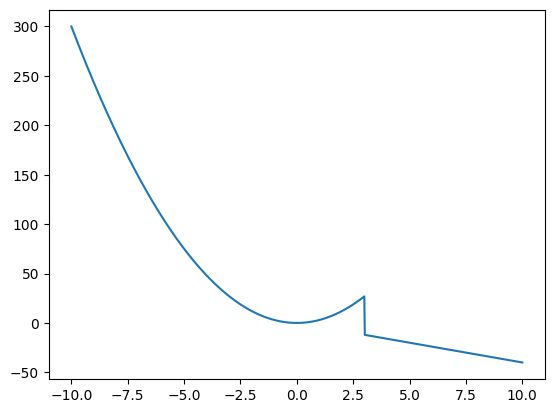

In [36]:
# Python control flow + grad() --> Everything is ok

def f(x):
    if x<3:
        return 3.*x**2
    else:
        return -4*x
    
x = np.linspace(-10, 10, 1000)
y = [f(el) for el in x]
plt.plot(x,y)
plt.show()

In [37]:
print(grad(f)(2.))      # Works ok!
print(grad(f)(4.))      # Works ok!

12.0
-4.0


In [38]:
# Python Control Flow + jit() --> Problems!

# The trade-off with higher levels of abstraction is we gain more general view
# of Python code (and thus save on recompilations),
# But we also require more constraints on the Python code to complete the trace

# Example 1: Conditioning on Value (Same function as above)
# Solution: (Recall, we have seen this)

f_jit = jit(f, static_argnums=(0,))
x=2.

print(jax.make_jaxpr(f_jit, static_argnums=(0,))(x))
print(f_jit(x))

{ lambda ; . let
    a:f32[] = jit[name=f jaxpr={ lambda ; . let  in (12.0:f32[],) }] 
  in (a,) }
12.0


In [39]:
# Another Example - Range depends on value

def f(x, n):
    y = 0
    for i in range(n):
        y = y + x[i]
    return y

f_jit = jit(f, static_argnums=(1,))
x = (jnp.array([2.,3.,4.]), 15)

In [41]:
# Let's see how loop gets unrolled 
print(jax.make_jaxpr(f_jit, static_argnums=(1,))(*x))

{ lambda ; a:f32[3]. let
    b:f32[] = jit[
      name=f
      jaxpr={ lambda ; a:f32[3]. let
          c:f32[1] = slice[limit_indices=(1,) start_indices=(0,) strides=None] a
          d:f32[] = squeeze[dimensions=(0,)] c
          e:f32[] = add 0.0:f32[] d
          f:f32[1] = slice[limit_indices=(2,) start_indices=(1,) strides=None] a
          g:f32[] = squeeze[dimensions=(0,)] f
          h:f32[] = add e g
          i:f32[1] = slice[limit_indices=(3,) start_indices=(2,) strides=None] a
          j:f32[] = squeeze[dimensions=(0,)] i
          k:f32[] = add h j
          l:i32[1] = broadcast_in_dim[
            broadcast_dimensions=()
            shape=(1,)
            sharding=None
          ] 3:i32[]
          m:f32[] = gather[
            dimension_numbers=GatherDimensionNumbers(offset_dims=(), collapsed_slice_dims=(0,), start_index_map=(0,), operand_batching_dims=(), start_indices_batching_dims=())
            fill_value=None
            indices_are_sorted=True
            mode=G

In [42]:
print(f_jit(*x))

57.0


##### Note: There is a catch - Static Arguments should not change a lot

In [43]:
# It is sometimes better (tho less readable) to use low level API

def f_fori(x, n):
    body_func = lambda i, val: val + x[i]
    return lax.fori_loop(0, n, body_func, 0.)

f_fori_jit = jit(f_fori)

print(jax.make_jaxpr(f_fori_jit)(*x))


{ lambda ; a:f32[3] b:i32[]. let
    c:f32[] = jit[
      name=f_fori
      jaxpr={ lambda ; a:f32[3] b:i32[]. let
          _:i32[] _:i32[] c:f32[] = while[
            body_jaxpr={ lambda ; d:f32[3] e:i32[] f:i32[] g:f32[]. let
                h:i32[] = add e 1:i32[]
                i:bool[] = lt e 0:i32[]
                j:i32[] = convert_element_type[new_dtype=int32 weak_type=False] e
                k:i32[] = add j 3:i32[]
                l:i32[] = select_n i e k
                m:f32[1] = dynamic_slice[slice_sizes=(1,)] d l
                n:f32[] = squeeze[dimensions=(0,)] m
                o:f32[] = convert_element_type[
                  new_dtype=float32
                  weak_type=False
                ] g
                p:f32[] = add o n
              in (h, f, p) }
            body_nconsts=1
            cond_jaxpr={ lambda ; q:i32[] r:i32[] s:f32[]. let
                t:bool[] = lt q r
              in (t,) }
            cond_nconsts=0
          ] a 0:i32[] b 0.0:f32[]
 

In [44]:
print(f_fori_jit(*x))

57.0


In [47]:
# Another Example: But this is not problematic

def log2_if_rank2(x):
    if x.ndim==2:
        ln_x = jnp.log(x)
        ln_2 = jnp.log(2.0)
        return ln_x/ln_2
    else:
        return x
    
print(jax.make_jaxpr(log2_if_rank2)(jnp.array([1,2,3])))

{ lambda ; a:i32[3]. let  in (a,) }


## Gotcha #7: NaNs

In [48]:
jnp.divide(0., 0.)

Array(nan, dtype=float32, weak_type=True)

In [51]:
# As we saw, NaNs can come from anywhere!
# This is because the default non-error behavior is to return a NaN

# If you want to debug where these NaNs are coming from, there are multiple ways!
# Here is one:

from jax import config
config.update("jax_debug_nans", True)

In [52]:
jnp.divide(0., 0.)

Invalid nan value encountered in the output of a jax.jit function. Calling the de-optimized version.


FloatingPointError: invalid value (nan) encountered in div

## Gotcha #8: JAX enforces single precision

In [53]:
# There are simple ways around it tho

x = jax.random.uniform(key, (1000,), dtype=jnp.float64)
print(x.dtype)

float32


C:\Users\gr8my\AppData\Local\Temp\ipykernel_45068\1375643272.py:3: UserWarning: Explicitly requested dtype float64 is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  x = jax.random.uniform(key, (1000,), dtype=jnp.float64)


### Final Conclusions<br>

- JAX is very powerful, device agnostic, excellent for researchers, etc
- Definitely way too complicated for beginners (functional paradigm, optimization details, etc) compared to PyTroch 